# Ahead of the Game: Coaching Predictability in NCAA Football

This notebook is Part III in a series that seeks to model the predictability of offenseive playcallers in the NCAA FBS football league. While this idea could be practically applied to any offensive playcaller in the game, we will use Lincoln Riley, the head coach of the Oklahoma Sooners, as a singular case study.

In [Part I](https://colab.research.google.com/drive/1ITENEu7jQ-3Hox3Mxr-TRgueKHElmwCH#offline=true&sandboxMode=true), we used all of Lincoln Riley's called plays to try to predict his coaching behavior. In [Part II](https://colab.research.google.com/drive/19qggMX5b_FWNvDxkJsxlwpzjAHW4fKl2#offline=true&sandboxMode=true) we found that a model of the Big XII Conference was an even better predictor of Lincoln Riley's coaching behavior. In this notebook, we will see how well a model of the entire NCAA's coaching behavior can accurately predict Mr. Riley's behavior.

**NOTE: This notebook is meant to be used in [Google Colaboratory](https://colab.research.google.com). The instructions will assume as much, and may not be accurate if you're using a different platform.**

We'll begin just as we have in the previous notebooks in this series by importing the base modules necessary to start and setting a random seed.

In [0]:
from numpy.random import seed
import random

seed(485)
random.seed(485)

In [0]:
import pandas as pd
import numpy as np
import tensorflow

##Preparing the Data
For this notebook, our data consists of all plays from all games in the NCAA FBS league between 2016 and 2019 - the years that Lincoln Riley has been a head coach in the league. Again, we'll hold out test set of the 2019 Big XII Championship Game.

As always, we'll have to load and transform the data for use in the model. I'll skip the explanations, but if you're looking for more discussion on what this data transformation looks like, refer to Part I of the series.

To import our data to Google Colab, you will first need to download the "leagueData.csv" from the models folder in the [GitHub repository](https://github.com/westpoint-neural-networks/final-project-NickL73). Next, you will need to click on the folder icon on the toolbar to the left of Google Colab and upload the dataset.

In [3]:
df = pd.read_csv('/content/leagueData.csv')
df

,score_differential,oneScoreGame,period,seconds_remaining,secondsInHalf,yardsToGoal,down,distance,play_type
0,-4,True,2,1990,190,75,1,10,Pass
1,-17,False,3,1497,1497,56,1,10,Pass
2,10,False,3,1317,1317,51,3,8,Pass
3,4,True,4,893,893,45,2,6,Pass
4,-41,False,4,101,101,62,3,7,Pass
...,...,...,...,...,...,...,...,...,...
98734,-16,False,3,1792,1792,99,1,10,Rush
98735,-20,False,3,927,927,99,1,10,Rush
98736,-6,True,1,2708,908,99,1,10,Rush
98737,5,True,1,3143,1343,92,4,4,Rush


You should note that we have *even more* data than before. We'll do all the same preprocessing as before, but just in one block to save some time and effort.

In [4]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

X = df.iloc[:,0:8]
y = df.iloc[:,8]

X = X.replace({True:1, False:0})
y = y.replace({'Rush':0, 'Pass':1})
y = to_categorical(y)

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.15)

ss = StandardScaler()
numeric = ['score_differential', 'period', 'seconds_remaining', 'secondsInHalf', 'yardsToGoal', 'down', 'distance']
scaled_features = X_train.copy()
features = scaled_features[numeric]
scaler = ss.fit(features.values)
features = ss.transform(features.values)

scaled_features[numeric] = features

X_train = scaled_features
X_train

Using TensorFlow backend.


,score_differential,oneScoreGame,period,seconds_remaining,secondsInHalf,yardsToGoal,down,distance
58515,0.452645,1,-1.342096,1.409503,1.071846,-0.057245,1.420007,-1.689187
19326,1.167600,0,0.443805,-0.192988,1.284711,1.182388,0.230412,-0.399646
12449,1.167600,0,1.336755,-1.347697,-0.901660,1.099746,1.420007,2.179436
69715,0.214327,1,-1.342096,1.380922,1.017728,0.769177,0.230412,-0.399646
56392,-0.619786,0,0.443805,-0.210137,1.252240,-1.834052,0.230412,-0.399646
...,...,...,...,...,...,...,...,...
22568,1.644236,0,0.443805,-0.361621,0.965414,-0.759703,0.230412,0.374079
83521,0.512225,0,0.443805,-0.032930,1.587772,-0.801024,1.420007,-1.173370
174,0.035589,1,-1.342096,1.272310,0.812079,1.306351,-0.959182,0.374079
57752,-1.036842,0,0.443805,-0.700793,0.323212,0.108040,1.420007,-0.915462


Repeat for the validation data.

In [5]:
scaled_features = X_validation.copy()
features = scaled_features[numeric]
features = ss.transform(features.values)

scaled_features[numeric] = features

X_validation = scaled_features
X_validation

,score_differential,oneScoreGame,period,seconds_remaining,secondsInHalf,yardsToGoal,down,distance
45546,0.035589,1,-0.449146,0.088067,-1.430214,0.108040,1.420007,-0.141738
30142,-0.143150,1,-0.449146,0.056627,-1.489744,-1.131593,-0.959182,0.374079
14355,-2.466751,0,1.336755,-1.630658,-1.437430,-1.420841,1.420007,-0.399646
52184,0.333486,1,1.336755,-1.230511,-0.679776,1.223709,-0.959182,0.374079
81115,0.273907,1,-0.449146,0.742593,-0.190910,-1.751409,0.230412,0.116171
...,...,...,...,...,...,...,...,...
15138,-0.619786,0,-0.449146,0.824527,-0.035771,0.686535,1.420007,-1.431278
87408,0.035589,1,-1.342096,1.125590,0.534273,0.975782,-0.959182,0.374079
66719,0.452645,1,-0.449146,0.817858,-0.048399,1.265030,0.230412,-0.399646
36522,0.035589,1,-0.449146,0.028045,-1.543862,-0.677061,1.420007,-0.915462


##Creating a model

The league model's architecture will differ from both the coaching and conference models. Again, we will primarily use a Densely connected network with **elu** activation functions, batch normalization, a final **sigmoid** activation, and a **binary crossentropy** loss function.

In [0]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(32, activation='elu', input_dim=8))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation='elu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation='elu'))
model.add(layers.Dense(2, activation='sigmoid'))

ad = optimizers.Adam(learning_rate=0.1)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

###Training the Model

We will use the same callback functions as we did in the conference model, and then train it like normal.

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# early stopping if training for more epochs
es_cb = EarlyStopping(monitor = 'val_loss', verbose=1, patience = 25, restore_best_weights=True)

#reduce learning rate on plateau
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

cb_list = [es_cb, rlr_cb]

In [8]:
history2 = model.fit(X_train, y_train,batch_size=24, epochs=1000, validation_data=(X_validation, y_validation), callbacks=cb_list)

Epoch 1/1000
3497/3497 [==============================] - 6s 2ms/step - loss: 0.6470 - accuracy: 0.6216 - val_loss: 0.6321 - val_accuracy: 0.6374 - lr: 0.0010
Epoch 2/1000
3497/3497 [==============================] - 6s 2ms/step - loss: 0.6358 - accuracy: 0.6324 - val_loss: 0.6262 - val_accuracy: 0.6409 - lr: 0.0010
Epoch 3/1000
3497/3497 [==============================] - 6s 2ms/step - loss: 0.6311 - accuracy: 0.6370 - val_loss: 0.6241 - val_accuracy: 0.6404 - lr: 0.0010
Epoch 4/1000
3497/3497 [==============================] - 6s 2ms/step - loss: 0.6282 - accuracy: 0.6376 - val_loss: 0.6208 - val_accuracy: 0.6437 - lr: 0.0010
Epoch 5/1000
3497/3497 [==============================] - 6s 2ms/step - loss: 0.6267 - accuracy: 0.6386 - val_loss: 0.6195 - val_accuracy: 0.6479 - lr: 0.0010
Epoch 6/1000
3497/3497 [==============================] - 6s 2ms/step - loss: 0.6258 - accuracy: 0.6429 - val_loss: 0.6186 - val_accuracy: 0.6461 - lr: 0.0010
Epoch 7/1000
3497/3497 [======================

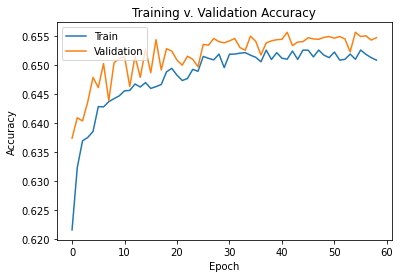

In [9]:
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Training v. Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Surprisingly, we seem to underfit the training data which suggests that our model could get even more accurate with a bit more tuning of the hyperparameters.

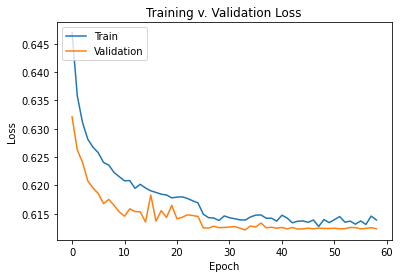

In [10]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Training v. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

This time, we see an even more gradual convergence of the training and validation losses as compared to the conference model. Now, we're ready to save and test the model.

**NOTE: The next block of code will save the model to the same content folder as our dataset in the Colab runtime. If you want to keep the model, be sure to right click and download it from the Colab directory.**

In [0]:
model.save('leagueModel.h5')

##Testing the Model

In this notebook, we built a model of the NCAA football league. This model describes the aggregate predictability of the league as a whole, but we're going to use it to see if it reveals anything when applied soley to Lincoln Riley.

Again, we'll use the 2019 Big XII Championship Game between Oklahoma and Baylor as our test case.

We'll start by reading in our test data and manipulating it for use in the model.

In [12]:
testDF = pd.read_csv('/content/test.csv')
XGame = testDF.iloc[:,0:8]
yGame= testDF.iloc[:,8]

XGame = XGame.replace({True:1, False:0})
yGame = yGame.replace({'Rush':0, 'Pass':1})
yGame = to_categorical(yGame)

scaled_features = XGame.copy()
features = scaled_features[numeric]
features = ss.transform(features.values)

scaled_features[numeric] = features

XGame = scaled_features
XGame

,score_differential,oneScoreGame,period,seconds_remaining,secondsInHalf,yardsToGoal,down,distance
0,0,True,1,3595,1795,75,1,10
1,0,True,1,3554,1754,72,2,7
2,0,True,1,3522,1722,70,3,5
3,0,True,1,3337,1537,78,1,10
4,0,True,1,3299,1499,7,1,7
...,...,...,...,...,...,...,...,...
69,0,True,4,119,119,52,2,8
70,0,True,4,74,74,47,3,3
71,0,True,5,-900,-900,23,1,10
72,0,True,5,-900,-900,11,1,10


###Evaluating Performance

Let's see how well our general league model can predict Lincoln Riley's play-calling in the test dataset.

In [14]:
model.evaluate(XGame, yGame)

3/3 [==============================] - 0s 2ms/step - loss: 0.6258 - accuracy: 0.6351


[0.625827968120575, 0.6351351141929626]

We observe here a 63.5% accuracy when applying the league model to Lincoln Riley - similar to the performance of the coaching model. This further suggests that Lincoln Riley conforms, at least to a meaningful degree, to the behavior of all coaches in the leage.

Let's take a look at the classification report.

In [15]:
from sklearn.metrics import classification_report

Y_test = np.argmax(yGame, axis=1) # Convert one-hot to index
y_pred = np.argmax(model.predict(XGame), axis=1)
print(classification_report(Y_test, y_pred, target_names=['Rush', 'Pass'], digits=5))

              precision    recall  f1-score   support

        Rush    0.70000   0.74468   0.72165        47
        Pass    0.50000   0.44444   0.47059        27

    accuracy                        0.63514        74
   macro avg    0.60000   0.59456   0.59612        74
weighted avg    0.62703   0.63514   0.63005        74



This is the same story as usual. It seems we really struggle in predicting more passes.

##Conclusion

This is the final part of a three part series to explore the predictability of Lincoln Riley, the head coach of the Oklahoma Sooners.

Ultimately, we found that we could accurately predict about 63% of his plays in a game, using the 2019 Big XII Championship Game as a single test case. In the application we will build with these models, we can use an ensemble that uses representations learned from each of our three models to create a prediction. Since each model was built a significantly different architecture, this could boost our performance on the test data.